In [336]:
import cv2
import numpy as np
import subprocess
import time
import datetime
import pytz
import matplotlib.colors as mcolors
from astral import LocationInfo
from astral.sun import sun
from scipy.interpolate import splprep, splev
from collections import deque
import multiprocessing
import matplotlib.pyplot as plt
import math

## Colors

In [20]:
def find_midpoint(start_time, end_time):
    return start_time + (end_time - start_time) / 2

def get_color(progress, start_color, end_color, exponent=1):
    c1 = np.array(mcolors.hex2color(start_color))
    c2 = np.array(mcolors.hex2color(end_color))
    color = (1 - progress**exponent) * c1 + progress**exponent * c2
    return tuple(int(255 * x) for x in color)

def get_colors():
    london_tz = pytz.timezone('Europe/London')
    london_datetime = datetime.datetime.now(london_tz)
    london_old_datetime = datetime.datetime.now(london_tz) - datetime.timedelta(days=1)
    london_next_datetime = datetime.datetime.now(london_tz) + datetime.timedelta(days=1)

    london_date = london_datetime.date()
    london_old_date = london_old_datetime.date()
    london_next_date = london_next_datetime.date()

    city = LocationInfo(latitude=51.537052, longitude=-0.183325)
    s = sun(city.observer, date=london_date)
    y = sun(city.observer, date=london_old_date)
    n = sun(city.observer, date=london_next_date)

    old_dusk = y['dusk'].astimezone(london_tz)
    current_dawn = s['dawn'].astimezone(london_tz)
    old_midnight = find_midpoint(old_dusk, current_dawn)

    current_dusk = s['dusk'].astimezone(london_tz)
    current_sunrise = s['sunrise'].astimezone(london_tz)
    current_sunset = s['sunset'].astimezone(london_tz)
    current_noon = find_midpoint(current_sunrise, current_sunset)
    next_dawn = n['dawn'].astimezone(london_tz)
    current_midnight = find_midpoint(current_dusk, next_dawn)

    color_lookup = {
        'midnight': {
            'line': {
                'start': '#ced4da',
                'end': '#f8f9fa'
            },
            'background': {
                'start': '#6c757d',
                'end': '#212529',
            },
            'exponent': 0.25
        },
        'dawn': {
            'line': {
                'start': '#f8f9fa',
                'end': '#ced4da'
            },
            'background': {
                'start': '#212529',
                'end': '#6c757d'
            },
            'exponent': 4
        },
        'sunrise': {
            'line': {
                'start': '#ced4da',
                'end': '#6c757d'
            },
            'background': {
                'start': '#6c757d',
                'end': '#ced4da'
            },
            'exponent': 4
        },
        'afternoon': {
            'line': {
                'start': '#6c757d',
                'end': '#212529'
            },
            'background': {
                'start': '#ced4da',
                'end': '#f8f9fa'
            },
            'exponent': .25
        },
        'sunset': {
            'line': {
                'start': '#212529',
                'end': '#6c757d'
            },
            'background': {
                'start': '#f8f9fa',
                'end': '#ced4da'
            },
            'exponent': 4
        },
        'dusk': {
            'line': {
                'start': '#6c757d',
                'end': '#ced4da'
            },
            'background': {
                'start': '#ced4da',
                'end': '#6c757d'
            },
            'exponent': .25
        }
    }

    if london_datetime <= old_midnight:
        approaching = 'midnight' 
        progress = (london_datetime - old_dusk).seconds / (old_midnight - old_dusk).seconds
    elif london_datetime <= current_dawn:
        approaching = 'dawn'
        progress = (london_datetime - old_midnight).seconds / (current_dawn - old_midnight).seconds
    elif london_datetime <= current_sunrise:
        approaching = 'sunrise'
        progress = (london_datetime - current_dawn).seconds / (current_sunrise - current_dawn).seconds
    elif london_datetime <= current_noon:
        approaching = 'afternoon'
        progress = (london_datetime - current_sunrise).seconds / (current_noon - current_sunrise).seconds
    elif london_datetime <= current_sunset:
        approaching = 'sunset'
        progress = (london_datetime - current_noon).seconds / (current_sunset - current_noon).seconds
    elif london_datetime <= current_dusk:
        approaching = 'dusk'
        progress = (london_datetime - current_sunset).seconds / (current_dusk - current_sunset).seconds
    elif london_datetime <= current_midnight:
        approaching = 'midnight' 
        progress = (london_datetime - current_dusk).seconds / (current_midnight - current_dusk).seconds
    else:
        return None
    line_color = get_color(progress=progress, start_color=color_lookup[approaching]['line']['start'], end_color=color_lookup[approaching]['line']['end'], exponent=color_lookup[approaching]['exponent'])
    background_color = get_color(progress=progress, start_color=color_lookup[approaching]['background']['start'], end_color=color_lookup[approaching]['background']['end'], exponent=color_lookup[approaching]['exponent'])
    return background_color, line_color


## Stream Input

In [2]:
def format_headers(headers):
    header_str = ""
    for key, value in headers.items():
        header_str += f"{key}: {value}\r\n"
    return header_str

def initialize_ffmpeg_process(headers, width, height):
    # Create FFmpeg command with custom headers
    ffmpeg_command = [
        'ffmpeg',
        '-headers', headers,
        '-i', 'https://videos-3.earthcam.com/fecnetwork/AbbeyRoadHD1.flv/chunklist_w.m3u8',
        '-f', 'rawvideo',
        '-pix_fmt', 'gray',
        '-s', f'{width}x{height}',
        '-r', '30',
        '-'
    ]
    process = subprocess.Popen(ffmpeg_command, stdout=subprocess.PIPE, bufsize=10**9)
    return process

height = 720
width = 1080
fps = 30
headers = {
    'Accept': '*/*',
    'Accept-Language': 'en-US,en;q=0.9',
    'Connection': 'keep-alive',
    'Origin': 'https://www.abbeyroad.com',
    'Referer': 'https://www.abbeyroad.com/',
    'Sec-Fetch-Dest': 'empty',
    'Sec-Fetch-Mode': 'cors',
    'Sec-Fetch-Site': 'cross-site',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36',
    'sec-ch-ua': '"Google Chrome";v="119", "Chromium";v="119", "Not?A_Brand";v="24"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"macOS"'
}
formatted_headers = format_headers(headers)

ffmpeg_process = initialize_ffmpeg_process(formatted_headers, width, height)

# Now you can continue with other tasks while ffmpeg is running
print("FFmpeg process started with PID:", ffmpeg_process.pid)

FFmpeg process started with PID: 4228


ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --

In [369]:
%%time
frame = ffmpeg_process.stdout.read(height * width)

CPU times: user 422 μs, sys: 650 μs, total: 1.07 ms
Wall time: 751 μs


In [370]:
%%time
array = np.frombuffer(frame, dtype=np.uint8).reshape((height, width))

CPU times: user 26 μs, sys: 0 ns, total: 26 μs
Wall time: 27.9 μs


In [393]:
%%time


CPU times: user 2.35 ms, sys: 1.69 ms, total: 4.03 ms
Wall time: 2.69 ms


In [421]:
%%time
gamma = 0.4  # Gamma value less than 1
inv_gamma = 1.0 / gamma

# Build a lookup table mapping pixel values [0, 255] to their adjusted gamma values
lookup_table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)], dtype=np.uint8)

# Apply the gamma correction using the lookup table
emphasized_darker = cv2.LUT(array, lookup_table)

CPU times: user 975 μs, sys: 528 μs, total: 1.5 ms
Wall time: 544 μs


In [427]:
%%time
edges = cv2.Canny(emphasized_darker, threshold1=125, threshold2=150, apertureSize=3)

CPU times: user 4.13 ms, sys: 897 μs, total: 5.02 ms
Wall time: 991 μs


In [372]:
%%time
transformed = 12 + 12 * np.sin(np.pi * higher_contrast / 255)

CPU times: user 13.3 ms, sys: 3.59 ms, total: 16.9 ms
Wall time: 14.4 ms


In [355]:
%%time
kernel = np.ones((9, 3), np.uint8)  # You can adjust the kernel size for different effects
dilated = cv2.dilate(higher_contrast, kernel, iterations=1)

CPU times: user 4.38 ms, sys: 2.6 ms, total: 6.98 ms
Wall time: 4.95 ms


In [359]:
%%time
kernel = np.ones((2, 3), np.uint8)
eroded = cv2.erode(higher_contrast, kernel, iterations=1)

CPU times: user 2.49 ms, sys: 2.28 ms, total: 4.77 ms
Wall time: 3.05 ms


CPU times: user 11.9 ms, sys: 2.16 ms, total: 14.1 ms
Wall time: 13 ms


CPU times: user 1.84 ms, sys: 1.25 ms, total: 3.09 ms
Wall time: 1.79 ms


In [344]:
%%time
darker_values = (25 / np.log(256)) * np.log1p(array)

CPU times: user 14.1 ms, sys: 1.63 ms, total: 15.8 ms
Wall time: 14.3 ms


CPU times: user 9.31 ms, sys: 3.05 ms, total: 12.4 ms
Wall time: 2.65 ms


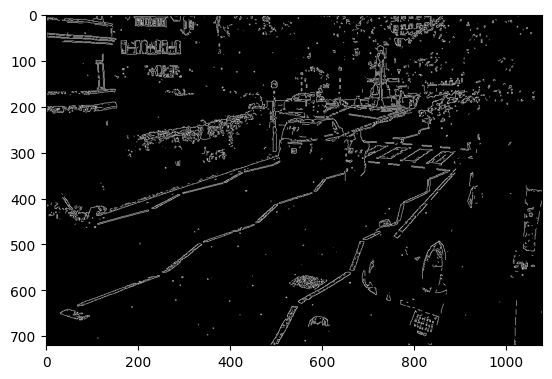

In [428]:
plt.imshow(edges, cmap='gray')

In [10]:
%%timeit
matrix_3d = np.full((height, width, 3), background_color, dtype=np.uint8)

2.83 ms ± 31.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%%timeit
matrix_3d = np.zeros((height, width, 3), dtype=np.uint8)
matrix_3d[:] = background_color

3.59 ms ± 21.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
x = 5